In [17]:
import os
import pathlib
import pickle
from shutil import unpack_archive
import shutil

import numpy as np
import scipy.stats as stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
class Loader:
    def __init__(self, occ, noise, ind, img_num):
        self.noise = noise
        self.img_num = img_num
        
        def gen_path(occ, noise, ind, img_num):
            P_path = os.path.join("known_curves","pre.pickle")
            R_path = os.path.join("known_curves","rec.pickle")
            occ_path = os.path.join("preprocessing", "labels", occ+"_l", noise, ind, ind+"_"+str(img_num)+"_occlusion.pickle")
            label_path = os.path.join("preprocessing", "labels", occ+"_l", noise, ind, ind+"_"+str(img_num)+"_label.pickle")
            return P_path, R_path, occ_path, label_path
        
        P_path, R_path, occ_path, label_path = gen_path(occ, noise, ind, img_num)
        with open(str(P_path), 'rb') as f:
            self.P = np.array(pickle.load(f))
        with open(str(R_path), 'rb') as f:
            self.R = np.array(pickle.load(f))
        with open(str(occ_path), 'rb') as f:
            self.occ = np.array(pickle.load(f))
        with open(str(label_path), 'rb') as f:
            self.label = np.array(pickle.load(f))

    def prop_occ(self):
        label_mode, _ = stats.mode(self.label, axis=0)
        label_mode = np.squeeze(label_mode).astype("int")
        self.occ = np.average(self.occ, axis=0)[label_mode]
        
    def prop_PR(self):
        sup_thes = list(range(8,64))[::-2]
        global_true_idx = [np.where((self.P>0.99)[:,i])[0]
                           if np.where((self.P>0.99)[:,i])[0].size != 0 
                           else np.array([-1])
                           for i in range(self.P.shape[1])]
        local_opt_idx = [np.argmax(self.R[:,i][global_true_idx[i]]) for i in range(len(global_true_idx))]
        global_opt_idx = [g_idx[l_idx] for g_idx, l_idx in zip(global_true_idx, local_opt_idx)]
        self.opt_sup_th = [sup_thes[opt_idx] for opt_idx in global_opt_idx]
    


In [19]:
occ = "q_a"
noise = "0mm"
ind = "q_1_a"
img_num = 64

In [20]:
opt_sup_dict = {}
lo = Loader(occ, noise, ind, img_num)
lo.prop_occ()
lo.prop_PR()
opt_sup_dict[(occ, noise, ind, img_num)] = lo.opt_sup_th

In [38]:
def temps_folder_path_unzip(occ, noise, ind, img_num):
    ind_folder = pathlib.Path(os.path.join("temps", occ, noise, ind))
    num_files = ind_folder.glob("*.*")
    temp_folder = ind_folder/"temp"
    if temp_folder.exists():
        shutil.rmtree(str(temp_folder))
    for num_file in num_files:
        if num_file.name.split(".")[0] != str(img_num):
            continue
        if num_file.suffix == ".zip":
            unpack_archive(filename=str(num_file), extract_dir=str(ind_folder), format="zip")
        else:
            unpack_archive(filename=str(num_file), extract_dir=str(ind_folder), format="gztar")
    return temp_folder

def get_tags(temp_folder):
    tags_path = list(temp_folder.glob("*.TDlines"))

    tags = []
    for tag_path in tags_path:
        tag_sp = tag_path.stem.split("_")
        tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
        tags.append(tag_arr)
    return tags            

def support_th(tags, temp_folder, sup_th):
    curve_fragment = []
    for tag in tags:
        if tag[1] == "R":
            continue

        with open(os.path.join(temp_folder, "{0}_{1}_{2}.TDlines".format(tag[0][0],tag[0][1],tag[1])), 'rb') as f:
            lines_list = pickle.load(f)

        with open(os.path.join(temp_folder, "{0}_{1}_{2}.support_dict".format(tag[0][0],tag[0][1],tag[1])), 'rb') as f:
            support_list, support_ac = pickle.load(f)
        #support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
        tag_list = []
        for col, sup_col, ac_col in zip(lines_list, support_list, support_ac):
            col_curve_fragment = []
            for frag, sup, sup_ac in zip(col, sup_col, ac_col):
                if sup > sup_th:
                    frag = np.reshape(frag,(-1, 3))
                    frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
                    col_curve_fragment.append(frag)
            tag_list.append(col_curve_fragment)
        curve_fragment.append(tag_list)
    return curve_fragment

def curve_fragment_align(curve_fragment):
    cfs = [[] for i in range(46)]
    for cols in curve_fragment:
        for i in range(len(cols)):
            cfs[i] += cols[i]
    temp_cfs = []
    for i, cf_label in enumerate(cfs):
        A = [frag  for frag in cf_label if frag.size!=0]
        temp_cfs.append(A)
    cfs = temp_cfs
    return cfs

In [39]:
for info in opt_sup_dict:
    occ, noise, ind, img_num = info
    output_file = os.path.join("known_opt_curve_fragment", "cfs.pickle")
    os.makedirs("known_opt_curve_fragment", exist_ok=True)
    #if os.path.exists(output_file):
    #    continue
    temp_folder = pathlib.Path("temp")
    tags = get_tags(temp_folder)
    temp_cfs = []
    for i, osth in enumerate(opt_sup_dict[info]):
        curve_fragment = support_th(tags, temp_folder, osth)
        cfs = curve_fragment_align(curve_fragment)
        temp_cfs.append(cfs[i])
        with open(os.path.join("known_opt_curve_fragment", "cfs.pickle"), 'wb') as f:
            pickle.dump(temp_cfs, f)

In [42]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(temp_cfs)):
        for frag in temp_cfs[i]:
            if i != 6:
                continue
            
            if frag.size < 10:
                continue
            #print(frag)
            
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            except UnboundLocalError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            if j % 1 == 0:
                ax.plot(new[0], new[2], new[1],"-",color=c)
            
            j+=1


<IPython.core.display.Javascript object>


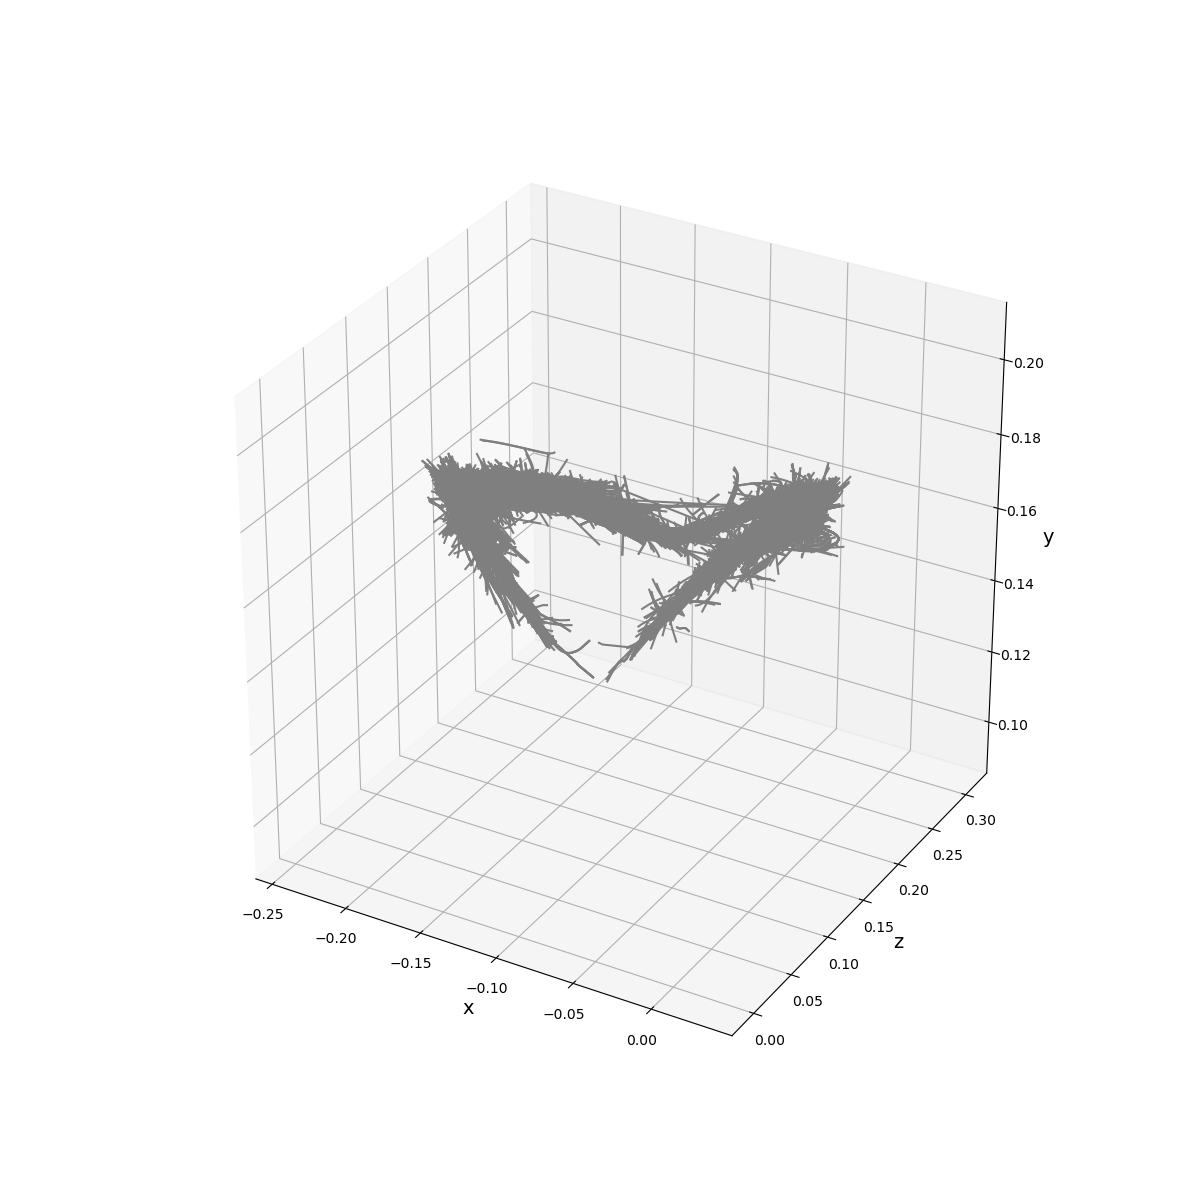

In [43]:
%matplotlib notebook
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))
#ax.set_xticks(np.arange(-4,4,1))
#ax.set_yticks(np.arange(-4,4,1))
#ax.set_zticks(np.arange(-2,9,1))

plot_graph()